In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit
from matplotlib_scalebar.scalebar import ScaleBar
path_figs = 'Figs/'

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.3
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9
visual_drift_adaptive_coef = 0

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import sklearn
# from numba import jit
# from matplotlib_scalebar.scalebar import ScaleBar
# path_figs = 'Figs/'

# visual_drift_coef = 1
# visual_drift_min = 0.8
# memory_drift_coef = 0.3
# memory_drift_adaptive_coef_activation = 0.3
# memory_drift_adaptive_coef_deactivation = 0.5
# visual_drift_adaptive_coef = 0

In [3]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result


def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [4]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'

seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'

seq_length = len(seq)
# window_sizes = [1,2,3,4,11]
window_sizes = [2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

visual_delay = 90
motor_delay = 50

diffusion = 2
threshold = 350
alpha = 0.9985
beta = 0.0005


# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]

In [5]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

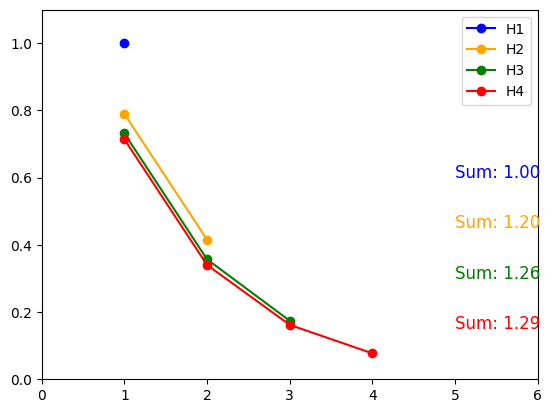

In [6]:
import matplotlib.pyplot as plt

# Original data points
blue_points = [1]
orange_points = [0.78947368, 0.41551247]
green_points = [0.73170732, 0.3569304 , 0.17411239]
red_points = [0.71428571, 0.34013605, 0.16196955, 0.07712836]

# Calculate the sums
blue_sum = sum(blue_points)
orange_sum = sum(orange_points)
green_sum = sum(green_points)
red_sum = sum(red_points)

# Original plot
plt.plot([1], blue_points, 'o-', color='blue', label = 'H1')
plt.plot([1, 2], orange_points, 'o-', color='orange', label = 'H2')
plt.plot([1, 2, 3], green_points, 'o-', color='green', label = 'H3')
plt.plot([1, 2, 3, 4], red_points, 'o-', color='red', label = 'H4')

# Adding the sums on the side
plt.text(5, 0.6, f'Sum: {blue_sum:.2f}', fontsize=12, color='blue')
plt.text(5, 0.45, f'Sum: {orange_sum:.2f}', fontsize=12, color='orange')
plt.text(5, 0.3, f'Sum: {green_sum:.2f}', fontsize=12, color='green')
plt.text(5, 0.15, f'Sum: {red_sum:.2f}', fontsize=12, color='red')

# Adjust plot limits to make room for text
plt.xlim(0, 6)
plt.ylim(0, 1.1)

plt.legend()
# Show plot
plt.show()


In [7]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [8]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef
            
            if press == current_press_planned:
                evidence[:, current_press_planned] += drifts_memory_dt[:, current_press_planned] * current_memory_coef

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            
        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [9]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7):
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drift_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, 
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drift_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(5,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press_planned:
                        for finger in range(5):
                            evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                            evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[:, current_press_planned: current_press_planned + 1] >= self.threshold).any():
                visible_window_size -= 1
                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                # print("current memory: ", current_memory_coef)
                # print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            

        for press in range(self.seq_length):
            for finger in range(5):
                sns.lineplot(x = np.arange(0, np.round(time, 2), self.dt), y = evidence_over_time[finger, press, :t_index], ax = axs[press], linestyle = '-',
                              label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_yticks([0, 350])
            axs[press].set_xlim([0, 5000])

            axs[press].tick_params(axis='x', labelrotation=45)
            axs[press].set_title(f'Press {press + 1}')
            axs[press].legend(loc = 'upper right')
        
        sns.despine(trim = True)
        plt.tight_layout()
        plt.savefig(path_figs + "Horse_Race.pdf", format = 'pdf', bbox_inches = 'tight')
        plt.show()

In [10]:
def check_param_condition(params):
    if params[0] < params[1]:
        return False
    if params[2] < params[3]:
        return False
    if params[3] < params[4]:
        return False

    if params[0] < params[2]:
        return False
    
    if params[1] < params[3]:
        return False

    if 1 < params[0]:
        return False
    if (params[0] + params[1] < 1):
        return False
    if (params[2] + params[3] + params[4] < params[0] + params[1]):
        return False


    else:
        return True

In [11]:
# from scipy.optimize import fmin
# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

# def loss(params, ipis_ideal):
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         corrs = []
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=4, planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi, _ = model.simulate()
#             corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             # corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#         # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):
#     params = np.array([0.78947368, 0.41551247,0.73170732, 0.3569304 , 0.17411239,0.71428571, 0.34013605, 0.16196955, 0.07712836])
#     # res = fmin(loss, params, args = (model, ipi_ideal), maxiter=100, xtol= 1e-8, ftol=1e-8)
#     res = fmin(loss, params, args = (ipis_ideal,), maxiter=1000)
    
#     return res

In [12]:
# from pyswarm import pso

# visual_drifts = calc_visual_drifts(random_seq, seq_length)
# memory_drifts = calc_memory_drifts(specific_seq, seq_length)
# optimzied_inds = [0, 1, 2, 3, 4, 10, 11, 12, 13]

# def loss(params, ipis_ideal):
#     corrs = []
#     if not check_param_condition(params):
#         return np.inf
#     else:
#         for window in [2,3,4]:
#             model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
#                 threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3,
#                   planning_param=params, alpha = alpha, beta = beta, seq_length = seq_length)
#             ipi_mean = np.array([])
#             n = 100
#             for _ in range(n):
#                 ipi, _ = model.simulate()
#                 ipi_mean = np.append(ipi_mean, ipi)
#             # ipi, _ = model.simulate()
#             ipi = ipi_mean.reshape(n, -1)
#             ipi = ipi.mean(axis = 0)
#             # corrs.append(-1 * np.corrcoef([ipi[idx] for idx in optimzied_inds], [ipis_ideal[window][idx] for idx in optimzied_inds])[0,1])
#             # corrs.append(-1 * np.corrcoef(ipi, ipis_ideal[window])[0,1])
#             # return -1 * np.corrcoef(ipi, ipi_ideal)[0,1]
#             # corrs.append(np.linalg.norm(np.array([ipi[idx] for idx in optimzied_inds]) - np.array([ipis_ideal[window][idx] for idx in optimzied_inds])))
#             corrs.append(np.linalg.norm(ipi - ipis_ideal[window]))
#         return sum(corrs)
#     # return np.sum((ipi - ipi_ideal)**2)
    

# def optimize(ipis_ideal):

#     lb = np.zeros(5)
#     ub = np.ones(5)
    
#     params_opt, loss_opt = pso(loss, lb, ub, args=(ipis_ideal,), maxiter=20, swarmsize=10000, debug=True)
    
#     return params_opt, loss_opt

In [13]:
# ipis_ideal = {
#     8: [751.27, 251.47, 276.2, 293.07, 310.93, 307.47, 319.47, 317.4, 330.2, 322.47, 347.93, 322.13, 299.07, 219.13],
#     3: [727.13, 251.67, 257.93, 326.8, 322.27, 319.47, 314.13, 322.33, 330.73, 331.8, 341.27, 319.6, 334.4, 227.87],
#     5: [735.67, 253.2, 277.4, 294.73, 308.07, 328.47, 319.6, 313.4, 306.07, 322.13, 332.4, 319.07, 294.87, 229.8],
#     2: [710.87, 268.27, 348.47, 325.0, 361.6, 340.93, 362.53, 350.53, 355.2, 349.2, 359.93, 368.93, 384.27, 273.73],
#     7: [736.93, 254.73, 263.33, 287.33, 309.0, 306.33, 309.27, 319.27, 317.2, 331.47, 339.0, 320.6, 315.0, 216.73],
#     13: [758.93, 258.27, 269.6, 300.47, 310.87, 304.33, 306.53, 327.13, 317.67, 309.53, 321.8, 326.27, 314.67, 212.47],
#     1: [644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93],
#     6: [747.07, 262.07, 276.53, 302.2, 306.47, 311.6, 329.33, 312.07, 320.33, 324.8, 334.27, 340.8, 312.8, 220.6],
#     4: [762.6, 252.73, 268.67, 287.67, 308.6, 316.47, 318.2, 318.4, 317.27, 319.2, 335.6, 326.67, 319.67, 216.93]
# }

ipis_ideal = {
    1: [644.53, 505.27, 512.47, 507.0, 518.53, 525.87, 528.0, 528.27, 519.73, 523.47, 527.2, 523.2, 526.07, 495.93],
    2: [710.87, 268.27, 348.47, 325.0, 361.6, 340.93, 362.53, 350.53, 355.2, 349.2, 359.93, 368.93, 384.27, 273.73],
    3: [727.13, 251.67, 257.93, 326.8, 322.27, 319.47, 314.13, 322.33, 330.73, 331.8, 341.27, 319.6, 334.4, 227.87],
    4: [745.93, 253.4, 270.13, 294.67, 307.6, 311.2, 315.13, 317.33, 318.0, 320.93, 332.33, 325.8, 306.07, 217.8]
}




In [14]:
# optimize(ipis_ideal)

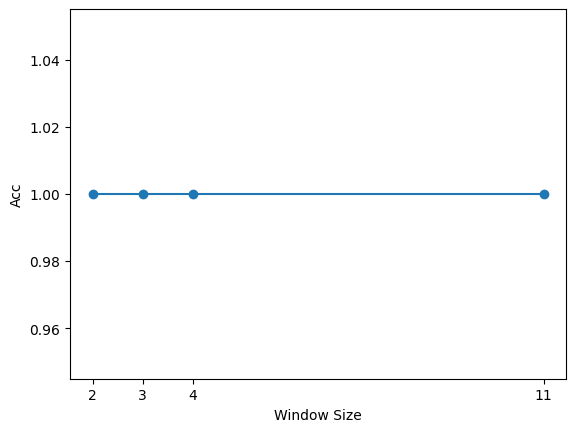

CPU times: user 55.5 s, sys: 754 ms, total: 56.2 s
Wall time: 56.7 s


In [193]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 1000
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold , window_size=window, visual_delay=visual_delay, motor_delay = motor_delay
    , planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(check_evidence_to_seq(evidence, random_seq))


#Calculating mean and std for each window size
MT_mean = {window: np.sum(MT_vals) for window, MT_vals in MT.items()}
# MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

# plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.errorbar(MT_mean.keys(), np.array(list(MT_mean.values()))/num_sims, fmt='-o')

plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Acc')
plt.show()


<timed exec>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F        PR(>F)
C(windowSize)               8.012904e+08     4.0   2725.754362  0.000000e+00
C(condition)                1.460537e+09     1.0  19873.269441  0.000000e+00
C(windowSize):C(condition)  3.041775e+06     4.0     10.347224  2.707241e-08
Residual                    1.462502e+08  1990.0           NaN           NaN


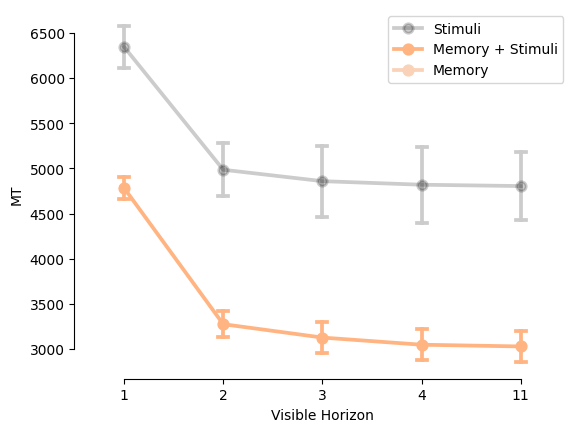

CPU times: user 45.8 s, sys: 1.55 s, total: 47.4 s
Wall time: 46.9 s


In [148]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols


trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'memory': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Stimuli', capsize=0.1, **kwargs[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory + Stimuli', capsize=0.1, **kwargs[label])
ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'memory'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, np.zeros((5, seq_length)), memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Memory', capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')
# plt.ylim([3000, 5500])

# legend labels

plt.legend(loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_54967/135908214.py:42: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
<timed exec>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F        PR(>F)
C(windowSize)               1.393951e+07     3.0     62.769833  2.343381e-38
C(condition)                1.220943e+09     1.0  16493.785906  0.000000e+00
C(windowSize):C(condition)  1.121885e+05     3.0      0.505187  6.787403e-01
Residual                    1.178469e+08  1592.0           NaN           NaN


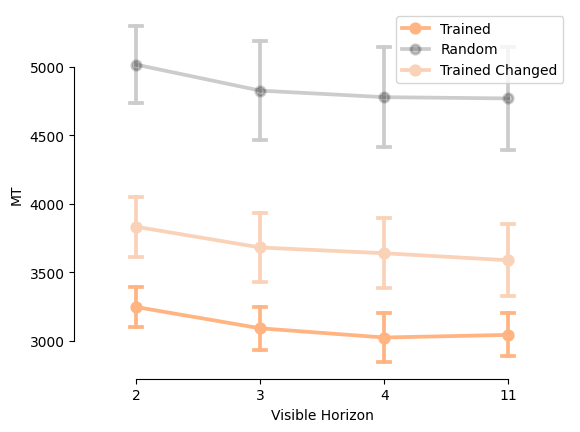

CPU times: user 33.8 s, sys: 2.18 s, total: 36 s
Wall time: 34.1 s


In [22]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


<timed exec>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F        PR(>F)
C(windowSize)               1.288169e+07     3.0     54.061613  2.827684e-33
C(condition)                1.191263e+09     1.0  14998.402245  0.000000e+00
C(windowSize):C(condition)  4.019191e+05     3.0      1.686766  1.678956e-01
Residual                    1.264462e+08  1592.0           NaN           NaN


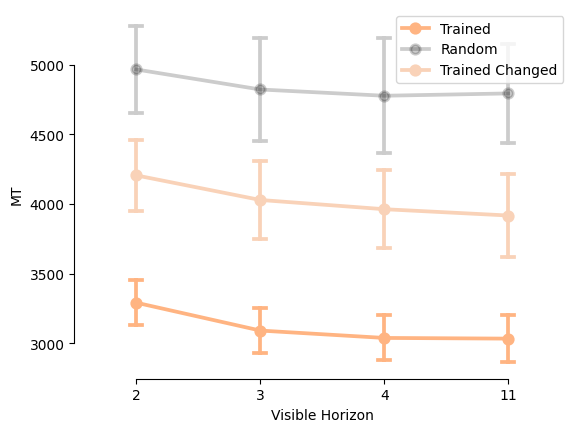

CPU times: user 30.5 s, sys: 1.78 s, total: 32.3 s
Wall time: 30.8 s


In [23]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
plt.savefig(path_figs + "MT_test_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


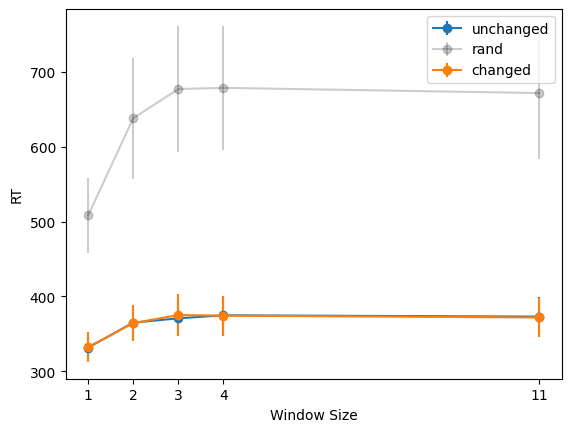

CPU times: user 1min 41s, sys: 2.11 s, total: 1min 43s
Wall time: 1min 45s


In [31]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
    window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])



visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq_changed, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold,
     window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


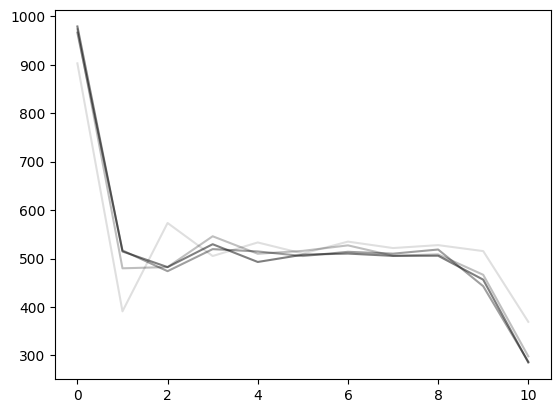

CPU times: user 28.7 s, sys: 492 ms, total: 29.2 s
Wall time: 29.7 s


In [554]:
%%time 
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length, dt= 1)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.ylim([100,550])
# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


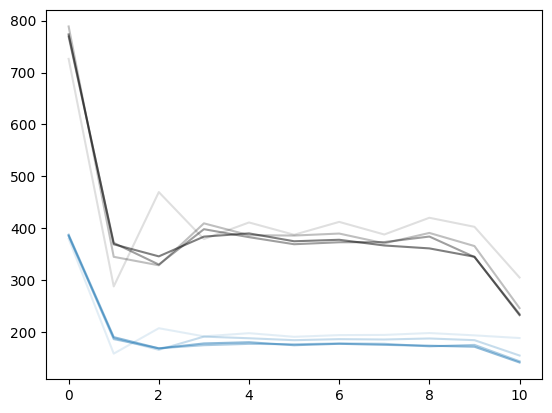

CPU times: user 44.6 s, sys: 1.06 s, total: 45.6 s
Wall time: 46.5 s


In [331]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
num_sims = 500


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, 
    memory_drifts, diffusion = diffusion, threshold = threshold, window_size=window, 
    visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta, seq_length = seq_length)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))

# plt.legend()
# plt.ylim([100,700])
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


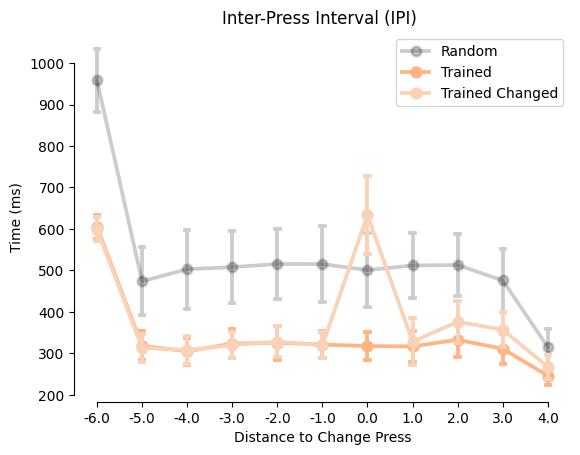

In [100]:
lookback_window = 7
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 100

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Time (ms)')
plt.title(f'Inter-Press Interval (IPI) ')


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')
plt.savefig(path_figs + "Perturbation_digit_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


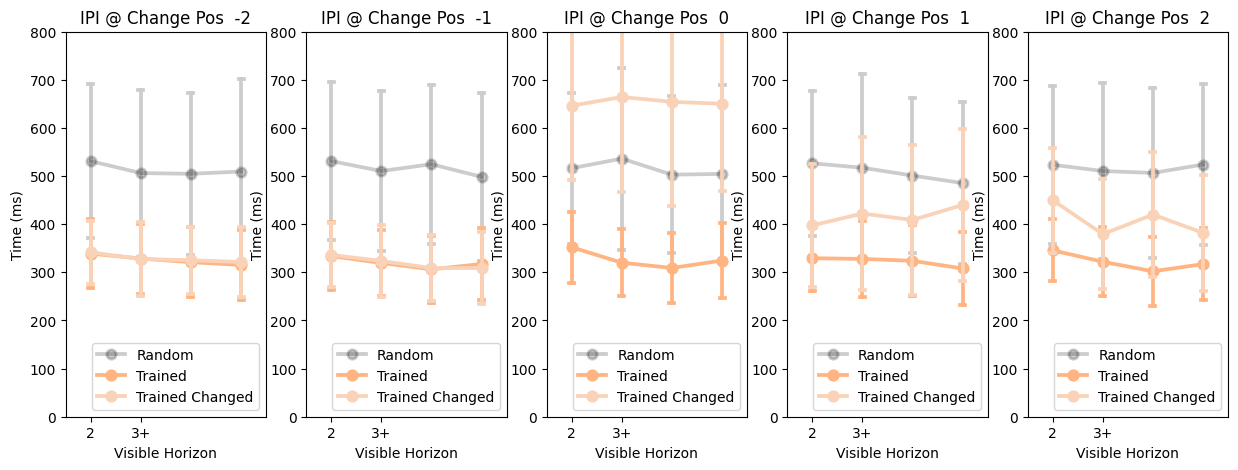

In [549]:

lookback_window = 3
change_idx = 6

fig, axs = plt.subplots(ncols=lookback_window * 2 - 1 , figsize= (15,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])







visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])

    handles, _ = axs[lookback + lookback_window - 1].get_legend_handles_labels()
    labels = ['Random', 'Trained', 'Trained Changed']
    axs[lookback + lookback_window - 1].legend(handles, labels, loc = 'lower right')

    axs[lookback + lookback_window - 1].set_xticks([0,1], ['2', '3+'])
    axs[lookback + lookback_window - 1].set_xlabel('Visible Horizon')
    axs[lookback + lookback_window - 1].set_ylabel('Time (ms)')
    axs[lookback + lookback_window - 1].set_title(f'IPI @ Change Pos  {lookback}')
    axs[lookback + lookback_window - 1].set_ylim([0, 800])






# plt.xlabel('Distance to Change Press')
# plt.ylabel('Time (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')


# sns.despine(trim=True)

# # legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Random', 'Trained', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')
# plt.show()


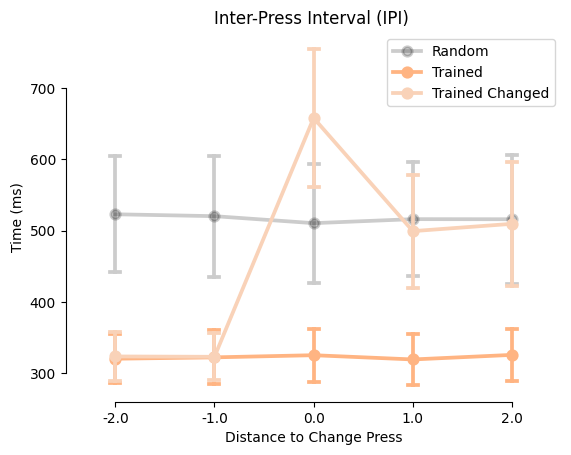

In [37]:
lookback_window = 3
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Time (ms)')
plt.title(f'Inter-Press Interval (IPI) ')


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')
plt.savefig(path_figs + "Perturbation_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()


/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_99577/1435721385.py:42: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]


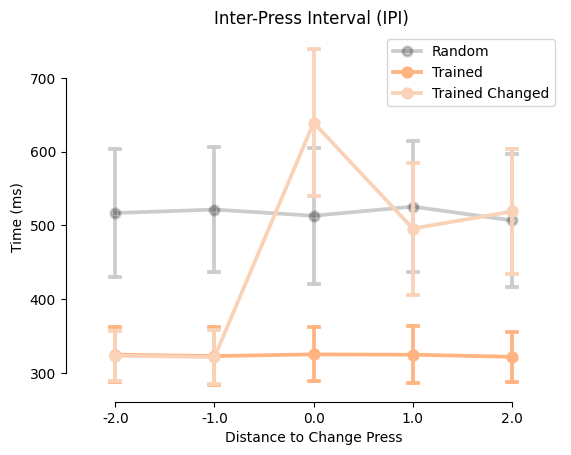

In [15]:
lookback_window = 3
change_idx = 6

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

IPI = IPI.groupby(['sim','dist_to_change']).agg({
    'IPI_Value': 'mean'
}).reset_index()

sns.pointplot(data = IPI, x = 'dist_to_change', y = 'IPI_Value', errorbar='sd',
             dodge = True, label = label, capsize = 0.1, **kwargs[label])



plt.xlabel('Distance to Change Press')
plt.ylabel('Time (ms)')
plt.title(f'Inter-Press Interval (IPI) ')


sns.despine(trim=True)

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Random', 'Trained', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')
# plt.savefig(path_figs + "Perturbation_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')

plt.show()


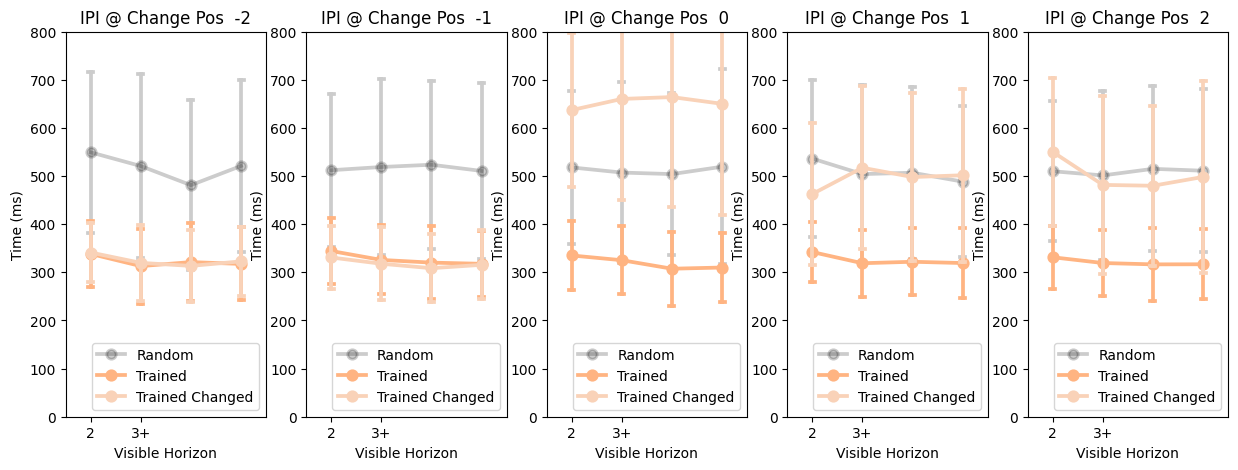

In [548]:

lookback_window = 3
change_idx = 6

fig, axs = plt.subplots(ncols=lookback_window * 2 - 1 , figsize= (15,5))

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}


num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'rand'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion= diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param, 
            alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])







visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'unchanged'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion , threshold= threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param,
              alpha = alpha, beta = beta, seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}
IPI = pd.DataFrame(columns = ['sim', 'window', 'IPI_Value','IPI_Number'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = diffusion, threshold = threshold, 
            window_size=window, visual_delay=visual_delay, motor_delay=motor_delay, planning_capacity=3, planning_param=param, alpha = alpha, beta = beta,
              seq_length=seq_length, memory_drift_coef=memory_drift_coef)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        for idx, IPI_value in enumerate(IPIs):
            IPI.loc[len(IPI)] = [sim, window, IPI_value, idx]

IPI['dist_to_change'] = (IPI['IPI_Number'] - change_idx)
IPI = IPI[IPI['dist_to_change'].isin(range(-lookback_window + 1, lookback_window))]

for lookback in range(-lookback_window + 1, lookback_window):
    data = IPI[IPI['dist_to_change'] == lookback]
    data = data.groupby(['sim','window']).agg({
        'IPI_Value': 'mean'
    }).reset_index()
    sns.pointplot(data = data, x = 'window', y = 'IPI_Value', errorbar='sd', dodge = True, label = label, capsize = 0.1, ax = axs[lookback + lookback_window - 1], **kwargs[label])

    handles, _ = axs[lookback + lookback_window - 1].get_legend_handles_labels()
    labels = ['Random', 'Trained', 'Trained Changed']
    axs[lookback + lookback_window - 1].legend(handles, labels, loc = 'lower right')

    axs[lookback + lookback_window - 1].set_xticks([0,1], ['2', '3+'])
    axs[lookback + lookback_window - 1].set_xlabel('Visible Horizon')
    axs[lookback + lookback_window - 1].set_ylabel('Time (ms)')
    axs[lookback + lookback_window - 1].set_title(f'IPI @ Change Pos  {lookback}')
    axs[lookback + lookback_window - 1].set_ylim([0, 800])






# plt.xlabel('Distance to Change Press')
# plt.ylabel('Time (ms)')
# plt.title(f'Inter-Press Interval (IPI) ')


# sns.despine(trim=True)

# # legend labels
# handles, _ = plt.gca().get_legend_handles_labels()
# labels = ['Random', 'Trained', 'Trained Changed']
# plt.legend(handles, labels, loc='upper right')
# plt.show()


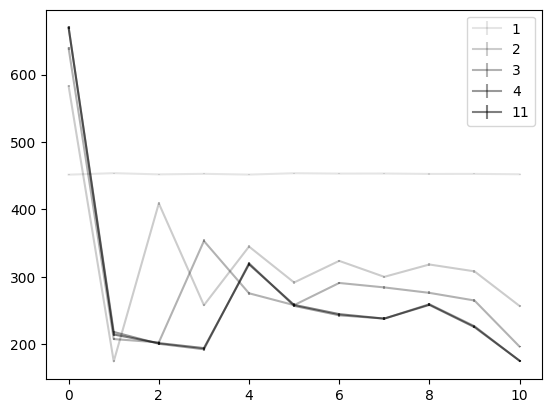

In [ ]:
num_sims = 10000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window], label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}


plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


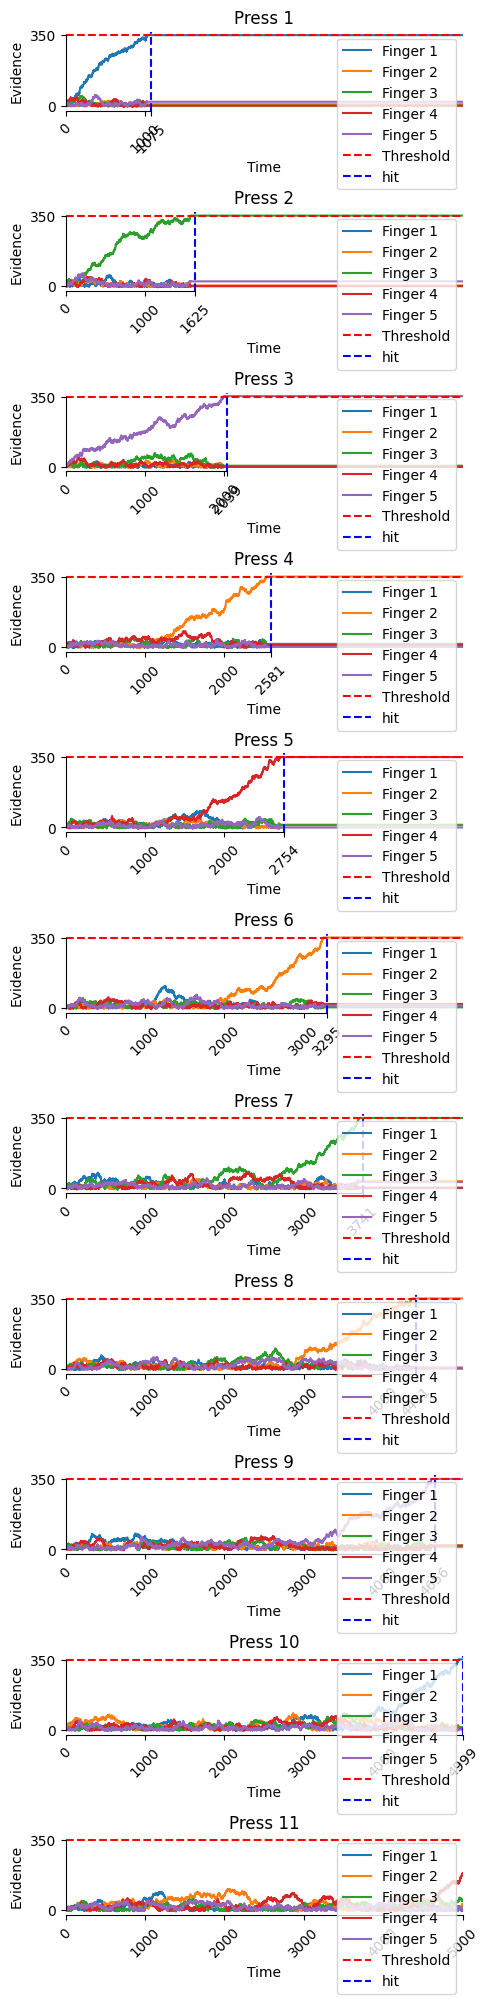

<Figure size 640x480 with 0 Axes>

In [176]:
visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                      diffusion = diffusion, threshold = threshold, visual_delay=visual_delay, motor_delay= motor_delay,
                                      planning_capacity=3, planning_param=param, seq_length=seq_length, alpha = alpha, beta = beta, window_size=11, 
                                      memory_drift_coef=memory_drift_coef)
model.plot_simulations()

# model.simulate()
# model.plot_IPIs()